## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt

#cv2.destroyAllWindows()

In [2]:
# calibrate the camera
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

mtx=None
dist=None    
img_size = None

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)


    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], mtx, dist)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)


In [3]:
img_width = img_size[0]
img_height = img_size[1]


selected_upper_width=20
selected_points = [[(img_width-selected_upper_width)/2,400],
                   [(img_width+selected_upper_width)/2,400],
                   [img_width-100,img_height],
                   [100,img_height]]

src = np.float32(selected_points)

dst = np.float32([[100,0],
                  [img_width-100,0], 
                  [img_width-100,img_height],                    
                  [100,img_height]])

#selected_points=[[547,480],[733,480],[1090,720],[190,720]]
#selected_points=[[550,480],[735,480],[1090,720],[190,720]]
src=np.float32([[550,480],[735,480],[1090,720],[190,720]])
dst = np.float32([[190,0],[1090,0],[1090,720],[190,720]])

# Given src and dst points, calculate the perspective transform matrix        
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
#warped = cv2.warpPerspective(undist, M, img_size)

#np.savez('mat.npz',img_size=img_size, mtx=mtx, dist=dist,M=M,Minv=Minv)



## And so on and so forth...

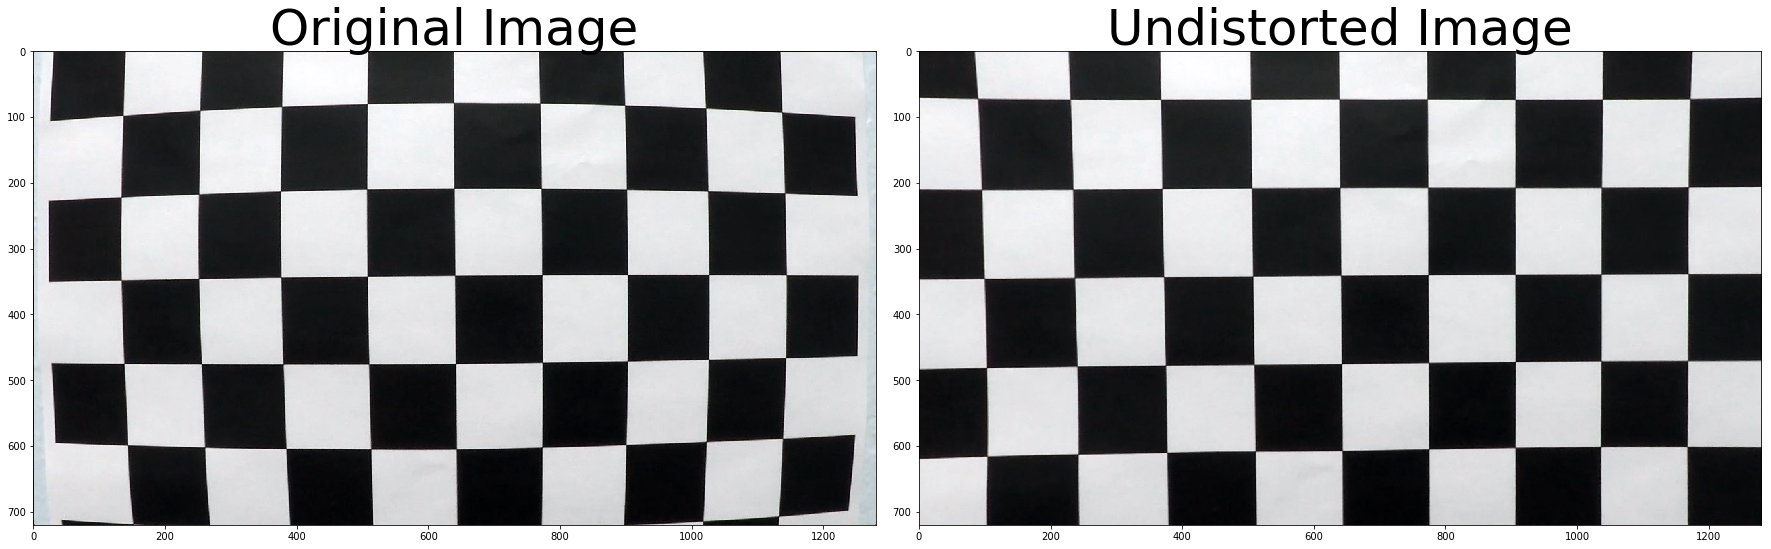

In [169]:
#for fname in images:
#    img = cv2.imread(fname)
#    undist = cv2.undistort(img, mtx, dist, None, mtx)
#    cv2.imshow('img',img)
#    cv2.waitKey(500)
#data = np.load('mat.npz')
#mtx=data['mtx']
#dist=data['dist']
#M=data['M']
#Minv=data['Minv']
#img_size = data['img_size']

img = cv2.imread('./camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()
#plt.imsave('unsitorted.png')

In [21]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    x=0
    y=0
    if orient=='y':
        y=1
    else:
        x=1
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2+sobely**2)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output
    

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absx = np.absolute(sobelx)
    absy = np.absolute(sobely)
    direction = np.arctan2(absy,absx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output
    
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    s_bin = abs_sobel_thresh(S, orient='x', thresh_min=20, thresh_max=100)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    combined = np.zeros_like(S)
    combined[(binary == 1) | (s_bin==1) ] = 1
    return combined
    
def getBinary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    
    s_bin = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)
    hls_binary = hls_select(img, thresh=(150, 225))


    combined = np.zeros_like(gradx)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary==1) ] = 1
    
    combined[(gradx == 1) | (hls_binary==1) ] = 1
    #show3x2(gradx,grady,mag_binary,hls_binary,combined,combined)

    return combined


In [163]:
class Lane:
    """A lane finding class"""
    left_fit = None
    right_fit = None
    left_fitx = None
    right_fitx = None
    ploty = None
    


class LaneFinder:
    """A lane finding class"""
    #camera params
    mtx=None
    dist=None
    M=None
    Minv=None
    img_size = None
    prev_lane = Lane()
    # pipeline images
    p_original = None
    p_undist = None
    p_warped = None
    p_wraped_binary = None
    p_histogram = None
    p_lane_mask = None
    p_undist_with_lane = None
    p_insight = None
    p_previous_estimate_width = None
    p_avg_estimated_width = 920
    
    def load_params(self):
        #self.data = np.load('mat.npz')
        #self.mtx=data['mtx']
        #self.dist=data['dist']
        #self.M=data['M']
        #self.Minv=data['Minv']
        self.mtx=mtx
        self.dist=dist
        self.M=M
        self.Minv=Minv

        
    def undistort(self):
        self.p_undist = cv2.undistort(self.p_original, self.mtx, self.dist, None, self.mtx)

    def wrap(self):
        self.p_warped = cv2.warpPerspective(self.p_undist, self.M, (self.img_size), flags=cv2.INTER_LINEAR)

    def getBinary(self):
        gray = cv2.cvtColor(self.p_warped, cv2.COLOR_BGR2GRAY)
        gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)
        #grady = abs_sobel_thresh(gray, orient='y', thresh_min=20, thresh_max=100)
        #mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100))
        #dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
        #s_bin = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=100)
        hls_binary = hls_select(self.p_warped, thresh=(150, 225))

        combined = np.zeros_like(gradx)
        #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary==1) ] = 1
        combined[(gradx == 1) | (hls_binary==1) ] = 1
        #show3x2(gradx,grady,mag_binary,hls_binary,combined,combined)
        self.p_wraped_binary = combined

       
    def find_lane_in_binary_warped(self, show=False):
        binary_warped = self.p_wraped_binary
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        self.p_histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        histogram = self.p_histogram
        # Create an output image to draw on and  visualize the result
        #vis_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        #print(binary_warped.dtype)
        #print(out_img.dtype)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
    
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                          (0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                          (0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
        # chose which lane to trust begin:
        left_lane_confidence = len(left_lane_inds)
        right_lane_confidence = len(right_lane_inds)
        #print(len(left_lane_inds))
        #print(len(right_lane_inds))
        trusted_line =  0 if(left_lane_confidence > right_lane_confidence) else 1
        #print(trusted_line)
        #end
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        #p_previous_estimate_width = estimate_width
        estimate_width = rightx_base-leftx_base
        #print(estimate_width)
        if abs(estimate_width - 920) > 100:
            estimate_width = 920
        #p_previous_estimate_width
        #if self.p_previous_estimate_width is not None:
        #    if abs(self.p_previous_estimate_width-estimate_width) > 50:
        #        estimate_width = self.p_avg_estimated_width
        self.p_avg_estimated_width = self.p_avg_estimated_width*0.9 + estimate_width*0.1
        #if abs(self.p_previous_estimate_width-estimate_width) > 50:
        #    estimate_width = self.p_avg_estimated_width
        
        if trusted_line==0:
            fixed_left_fit = left_fit
            fixed_right_fit = np.copy(left_fit)
            fixed_right_fit[2] += self.p_avg_estimated_width
            lane_pix_color = [255, 0, 0]
        else:
            fixed_right_fit = right_fit
            fixed_left_fit = np.copy(right_fit)
            fixed_left_fit[2] -= self.p_avg_estimated_width
            lane_pix_color = [0, 0, 255]

        #self.p_previous_estimate_width = estimate_width

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        fixed_right_fitx = fixed_right_fit[0]*ploty**2 + fixed_right_fit[1]*ploty + fixed_right_fit[2]
        fixed_left_fitx = fixed_left_fit[0]*ploty**2 + fixed_left_fit[1]*ploty + fixed_left_fit[2]
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = lane_pix_color
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = lane_pix_color
        
        # Color the area between the lines (the lane)
        #lane = np.zeros_like(img)  # Create a blank canvas to draw the lane on 
        left_points = np.array([np.vstack([fixed_left_fitx, ploty]).T])
        right_points = np.array([np.flipud(np.vstack([fixed_right_fitx, ploty]).T)])
        points = np.hstack((left_points, right_points))
        cv2.fillPoly(out_img, np.int_([points]), (0, 255, 0))
        out_img = cv2.warpPerspective(out_img, self.Minv, (self.p_original.shape[1], self.p_original.shape[0]))
        #drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
        if show:
            plt.imshow(out_img)
            #plt.plot(left_fitx, ploty, color='yellow')
            #plt.plot(right_fitx, ploty, color='yellow')
            #plt.plot(fixed_left_fitx, ploty, color='blue')
            #plt.plot(fixed_right_fitx, ploty, color='blue')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
        lane = Lane()
        lane.left_fit = fixed_left_fit
        lane.right_fit = fixed_right_fit
        lane.left_fitx = fixed_left_fitx
        lane.right_fitx = fixed_right_fitx
        lane.ploty = ploty
        
        # calculate curvature
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, fixed_left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, fixed_right_fitx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        lane_width = abs(fixed_left_fitx[-1] - fixed_right_fitx[-1])
        lane_center = (fixed_right_fitx[-1] + fixed_left_fitx[-1])//2
        offset_pix = 1280/2 - lane_center
        offset = (xm_per_pix * offset_pix)
        #print(offset)
        left_word = 'lane curvature: ' + str(left_curverad) +' m'
        offset_word = 'offset: ' + str(offset) +' m'
        
        #print(left_word)
        cv2.putText(self.p_undist, left_word, (100,100), 0, 1, (255, 255, 255))
        cv2.putText(self.p_undist, offset_word, (100,150), 0, 1, (255, 255, 255))
        
        # TODO if this lane is resonable then
        self.prev_lane = lane
        self.p_lane_mask = out_img


    #p_original = None
    #p_undist = None
    #p_warped = None
    #p_wraped_binary = None
    #p_lane_mask = None

    def get_insight_image(self):
        if self.p_histogram is not None:
            #fig = Figure()
            figure = plt.figure()
            plot = figure.add_subplot(111 )
            #subplots_adjust
            plot.plot(self.p_histogram)
            figure.canvas.draw()
            w,h = figure.canvas.get_width_height()
            buf = np.fromstring ( figure.canvas.tostring_rgb(), dtype=np.uint8 )
            buf.shape = ( w, h,3 )
            # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
            buf = np.roll ( buf, 3, axis = 2 )
            #hist_rgb = np.zeros_like(self.p_undist)
            #for i in range(0,1280):
            #    hist_rgb[self.p_histogram[i],i] = [255,0,0]
            #print(self.p_histogram.dtype)
            #print(self.p_histogram.shape)
            #self.p_insight[259:462,920:1280] = cv2.resize(buf,(360,203))
            #self.p_insight[0:506,0:900] = cv2.resize(buf,(900,506))
            plt.gcf().clear()

        self.p_insight = np.zeros_like(self.p_undist)
        self.p_insight[259:462,920:1280] = cv2.resize(buf,(360,203))
        binary_rgb = np.dstack((self.p_wraped_binary, self.p_wraped_binary, self.p_wraped_binary))*255
        self.p_insight[0:506,0:900] = cv2.resize(self.p_undist,(900,506))
        self.p_insight[517:720,0:360] = cv2.resize(self.p_warped,(360,203))
        self.p_insight[517:720,460:820] = cv2.resize(binary_rgb,(360,203))
        self.p_insight[517:720,920:1280] = cv2.resize(self.p_lane_mask,(360,203))
        self.p_insight[0:203,920:1280] = cv2.resize(self.p_original,(360,203))
        
        return self.p_insight


    def pipeline(self,img):
        self.p_original = img
        self.undistort()
        self.wrap()
        self.getBinary()
        self.find_lane_in_binary_warped()
        self.p_undist = cv2.addWeighted(self.p_undist, 1, self.p_lane_mask, 1, 0)

        return self.get_insight_image()


In [164]:
finder = LaneFinder()
finder.load_params()

img = cv2.imread('./test_images/test5.jpg')
origin = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

out_img = finder.pipeline(origin)
#insight_img = finder.get_insight_image()
#plt.imshow(out_img)
#plt.show()
plt.imsave('out_img.png',out_img)

In [165]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#f_name = 'challenge_video.mp4'
f_name = 'project_video.mp4'

video = VideoFileClip('./{}'.format(f_name))  # Load the original video
video = video.fl_image(finder.pipeline)  # Pipe the video frames through the lane-detection pipeline
# video = video.subclip(39, 43)  # Only process a portion
%time video.write_videofile('./output_videos/{}'.format(f_name), audio=False)  # Write the new video

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [07:19<00:00,  2.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 9min 19s, sys: 4min 20s, total: 13min 39s
Wall time: 7min 20s
